In [ ]:
pip install pymc3

In [ ]:
pip install scipy==1.7.3

In [ ]:
pip install --upgrade mkl

In [ ]:
pip install arviz==0.11.0

In [13]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy.stats import ttest_ind, mannwhitneyu
import scipy.stats as stats

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-grayscale")
rng = np.random.default_rng(seed=42)

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv(path)   

Experiment after adjustment

In [ ]:
y = data.loc[data['sku'] == 'SKU_7_3']
y = y.fillna(0)
y = y[['ofd_status_new', 'delta_rolling']]
y1 = y[y['ofd_status_new'] == 0]['delta_rolling']
y2 = y[y['ofd_status_new'] == 1]['delta_rolling']

In [ ]:
print(y1.mean(), y1.median(), y1.mode(), len(y1))
print(y2.mean(), y2.median(), y2.mode(), len(y2))

0.35932188804233894 0.0 0    0.0
Name: delta_rolling, dtype: float64 7747
0.3240248227021277 0.333333333 0    0.666667
Name: delta_rolling, dtype: float64 1504


(array([ 52.,  98., 256., 535., 282., 112.,  45.,  30.,   9.,   9.]),
 array([-10.,  -7.,  -4.,  -1.,   2.,   5.,   8.,  11.,  14.,  17.,  20.]),
 <BarContainer object of 10 artists>)

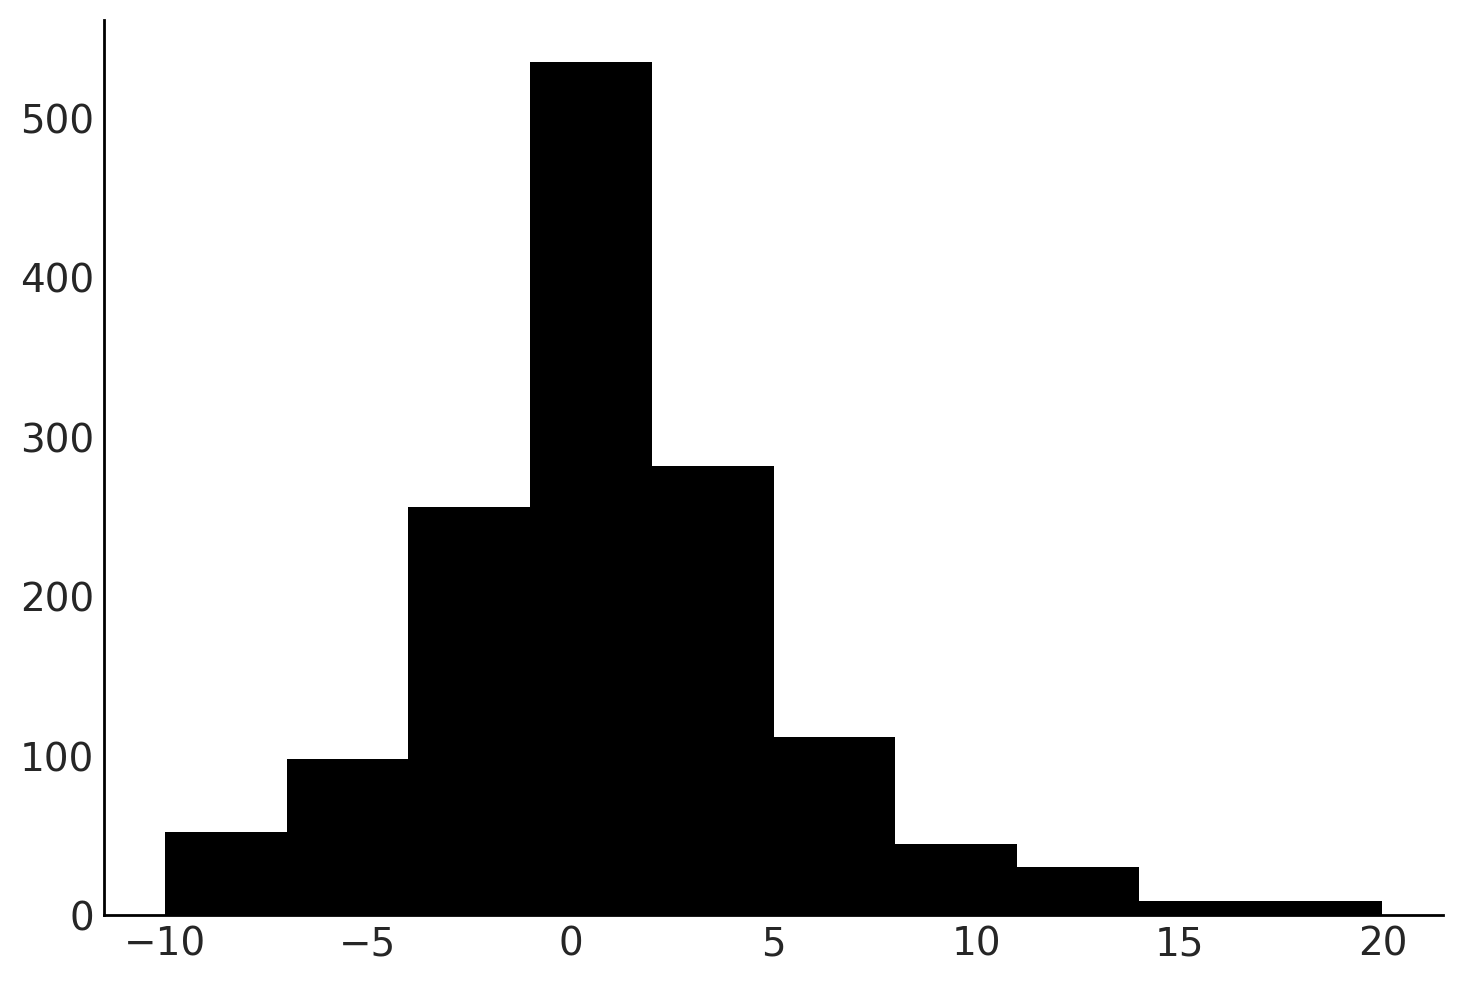

In [ ]:
plt.hist(y2, range=[-10, 20], bins=10)

<Axes: ylabel='Density'>

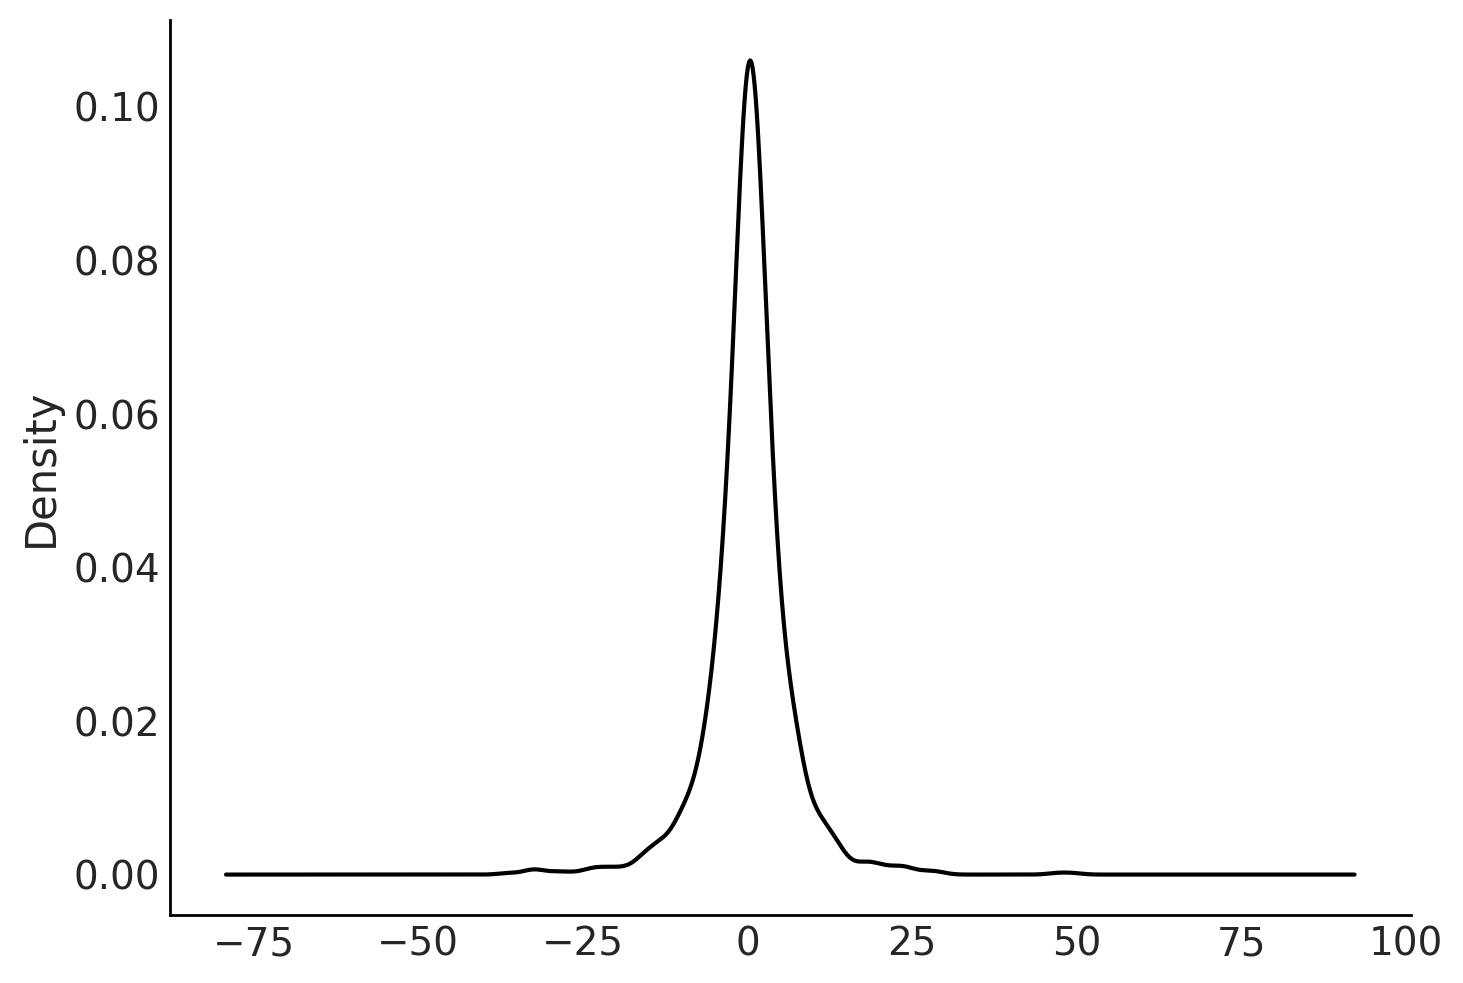

In [ ]:
y2.plot.kde()

In [ ]:
μ_m = y.delta_rolling.mean()
μ_s = y.delta_rolling.std() * 2
σ_low = 1/10
σ_high = 10

with pm.Model() as model:
    control_mean = pm.Normal('control_mean', mu=μ_m, sigma=μ_s)
    test_mean = pm.Normal('test_mean', mu=μ_m, sigma=μ_s)

    control_std = pm.Uniform('control_std', lower=σ_low, upper=σ_high)
    test_std = pm.Uniform('test_std', lower=σ_low, upper=σ_high)

    ν = pm.Exponential('ν_minus_one', 1 / 29.0) + 1

    λ1 = control_std ** -2
    λ2 = test_std ** -2

    control = pm.StudentT('control', nu=ν, mu=control_mean, lam=λ1, observed=y1)
    test = pm.StudentT('test', nu=ν, mu=test_mean, lam=λ2, observed=y2)

    diff_of_means = pm.Deterministic('difference of means', test_mean - control_mean)
    diff_of_stds = pm.Deterministic('difference of stds', test_std - control_std)
    effect_size = pm.Deterministic(
        'effect size', diff_of_means / np.sqrt((control_std ** 2 + test_std ** 2) / 2))     

In [ ]:
with model:
    trace = pm.sample(10000, return_inferencedata=True)

In [ ]:
(trace.posterior.test_mean > trace.posterior.control_mean).mean() #probability of superiority 

<xarray.DataArray ()>
array(0.999)

In [ ]:
az.summary(trace, var_names=['control_mean', 'test_mean', 'control_std', 'test_std', 'difference of means', 'difference of stds', 'effect size'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
control_mean         0.092  0.026   0.040    0.139      0.000      0.0   
test_mean            0.408  0.097   0.222    0.586      0.001      0.0   
control_std          1.795  0.031   1.737    1.853      0.000      0.0   
test_std             2.881  0.093   2.711    3.059      0.001      0.0   
difference of means  0.316  0.100   0.121    0.495      0.001      0.0   
difference of stds   1.086  0.092   0.917    1.264      0.001      0.0   
effect size          0.132  0.042   0.051    0.208      0.000      0.0   

                     ess_mean   ess_sd  ess_bulk  ess_tail  r_hat  
control_mean          28829.0  26560.0   28843.0   15991.0    1.0  
test_mean             24951.0  24072.0   24949.0   16230.0    1.0  
control_std           13459.0  13459.0   13454.0   15679.0    1.0  
test_std              19374.0  19328.0   19419.0   15605.0    1.0  
difference of means   25016.0  23272.0   25009.0   16006.0    1.0  
difference of stds    25686.0  25292.0   25761.0   15160.0    1.0  
effect size           24899.0  23326.0   24892.0   16401.0    1.0

array([[<Axes: title={'center': 'control_mean'}>,
        <Axes: title={'center': 'control_mean'}>],
       [<Axes: title={'center': 'test_mean'}>,
        <Axes: title={'center': 'test_mean'}>],
       [<Axes: title={'center': 'control_std'}>,
        <Axes: title={'center': 'control_std'}>],
       [<Axes: title={'center': 'test_std'}>,
        <Axes: title={'center': 'test_std'}>],
       [<Axes: title={'center': 'ν_minus_one'}>,
        <Axes: title={'center': 'ν_minus_one'}>],
       [<Axes: title={'center': 'difference of means'}>,
        <Axes: title={'center': 'difference of means'}>],
       [<Axes: title={'center': 'difference of stds'}>,
        <Axes: title={'center': 'difference of stds'}>],
       [<Axes: title={'center': 'effect size'}>,
        <Axes: title={'center': 'effect size'}>]], dtype=object)

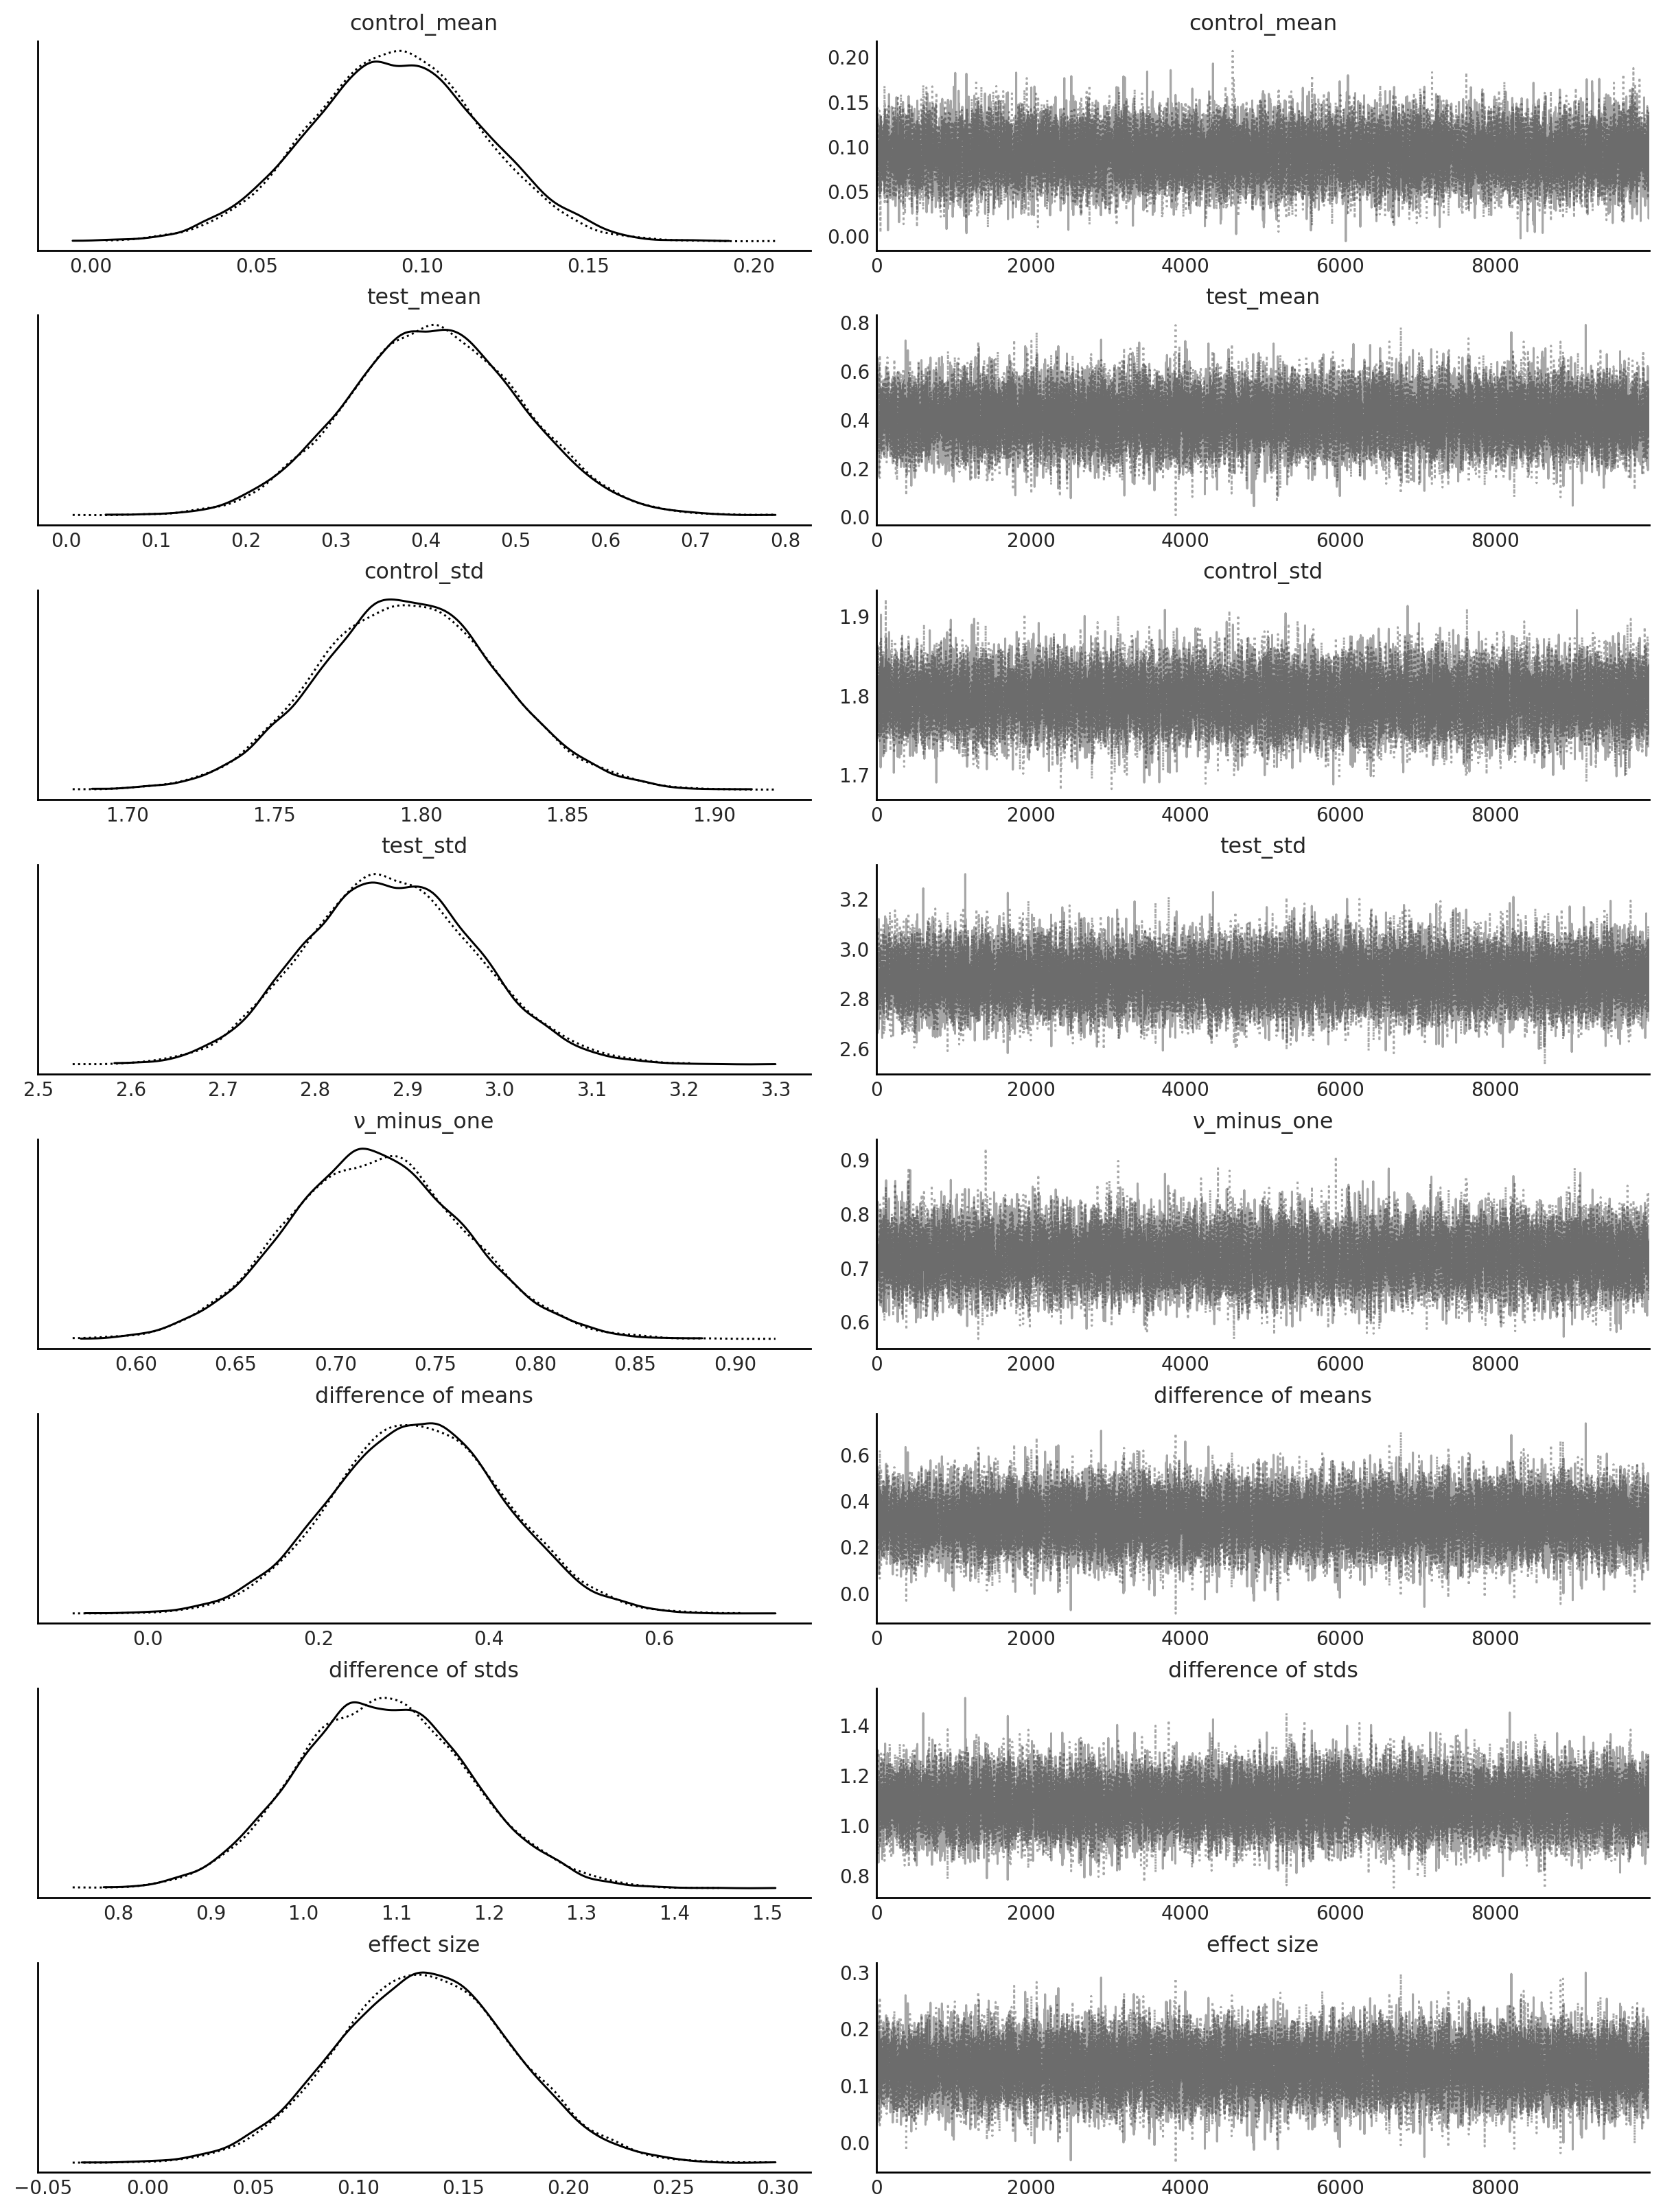

In [ ]:
az.plot_trace(trace)

array([[<Axes: title={'center': 'control_mean\n0'}>,
        <Axes: title={'center': 'control_mean\n1'}>,
        <Axes: title={'center': 'test_mean\n0'}>,
        <Axes: title={'center': 'test_mean\n1'}>],
       [<Axes: title={'center': 'control_std\n0'}>,
        <Axes: title={'center': 'control_std\n1'}>,
        <Axes: title={'center': 'test_std\n0'}>,
        <Axes: title={'center': 'test_std\n1'}>],
       [<Axes: title={'center': 'ν_minus_one\n0'}>,
        <Axes: title={'center': 'ν_minus_one\n1'}>,
        <Axes: title={'center': 'difference of means\n0'}>,
        <Axes: title={'center': 'difference of means\n1'}>],
       [<Axes: title={'center': 'difference of stds\n0'}>,
        <Axes: title={'center': 'difference of stds\n1'}>,
        <Axes: title={'center': 'effect size\n0'}>,
        <Axes: title={'center': 'effect size\n1'}>]], dtype=object)

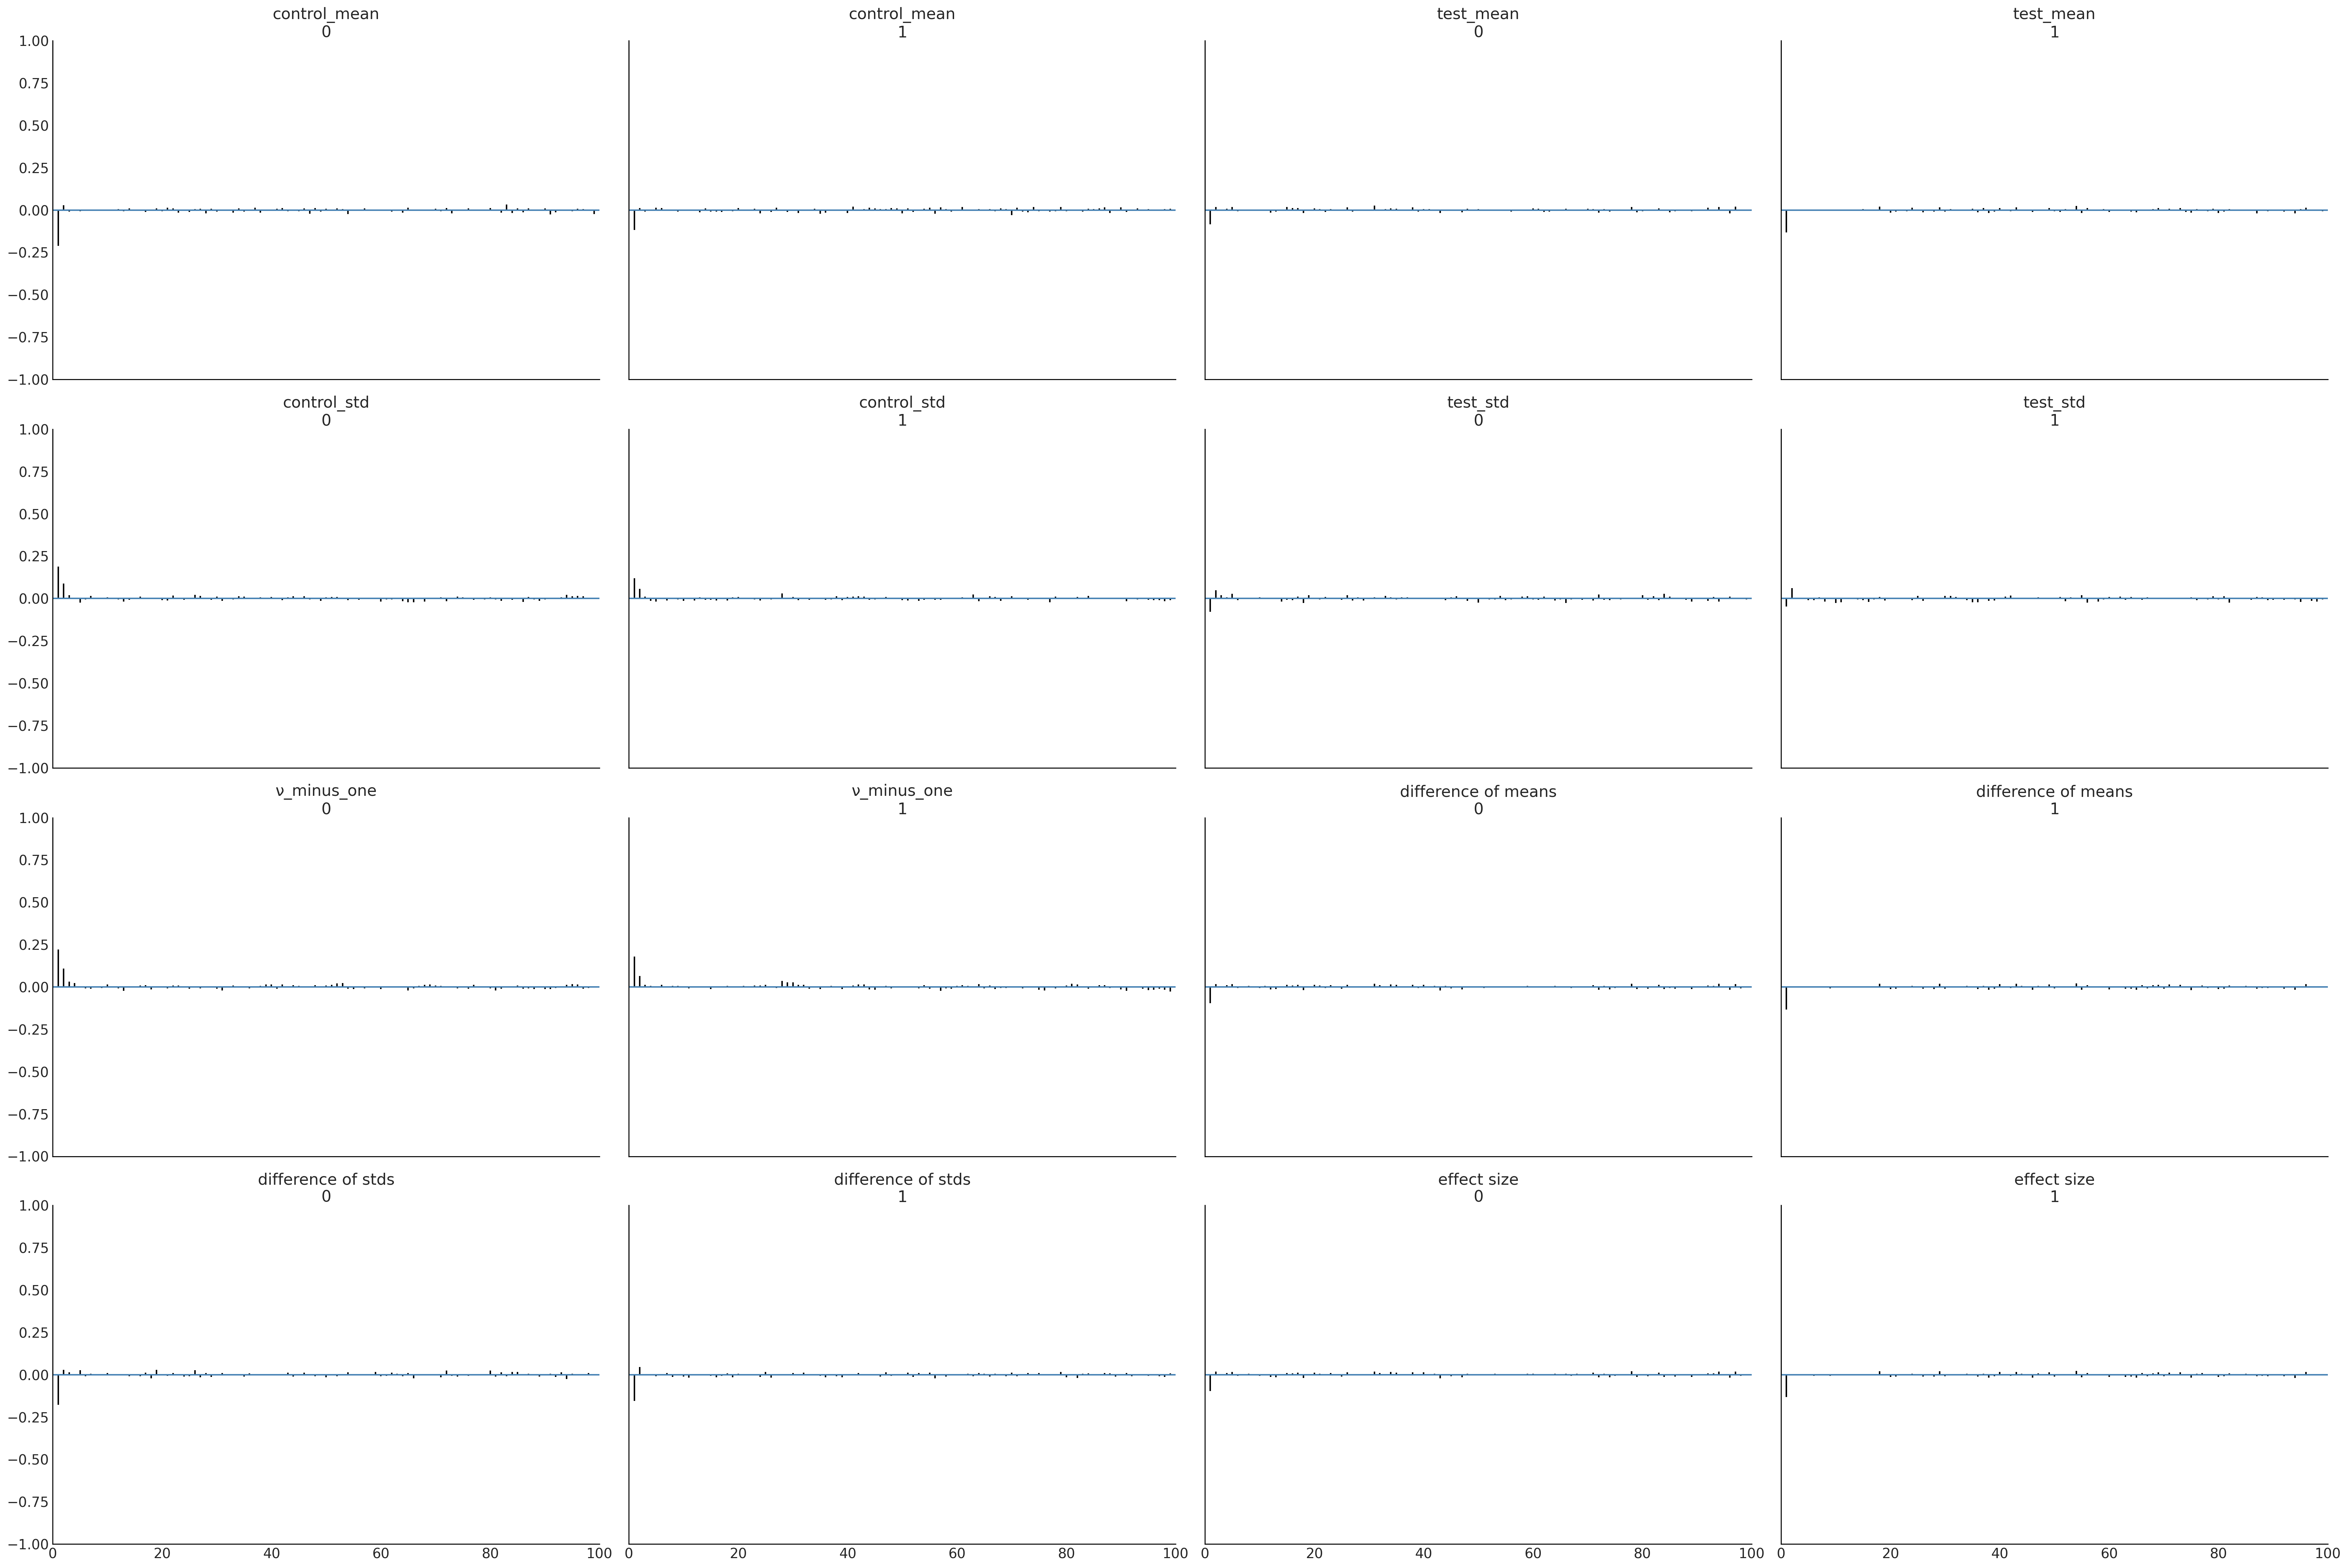

In [ ]:
az.plot_autocorr(trace) #, var_names='effect size')

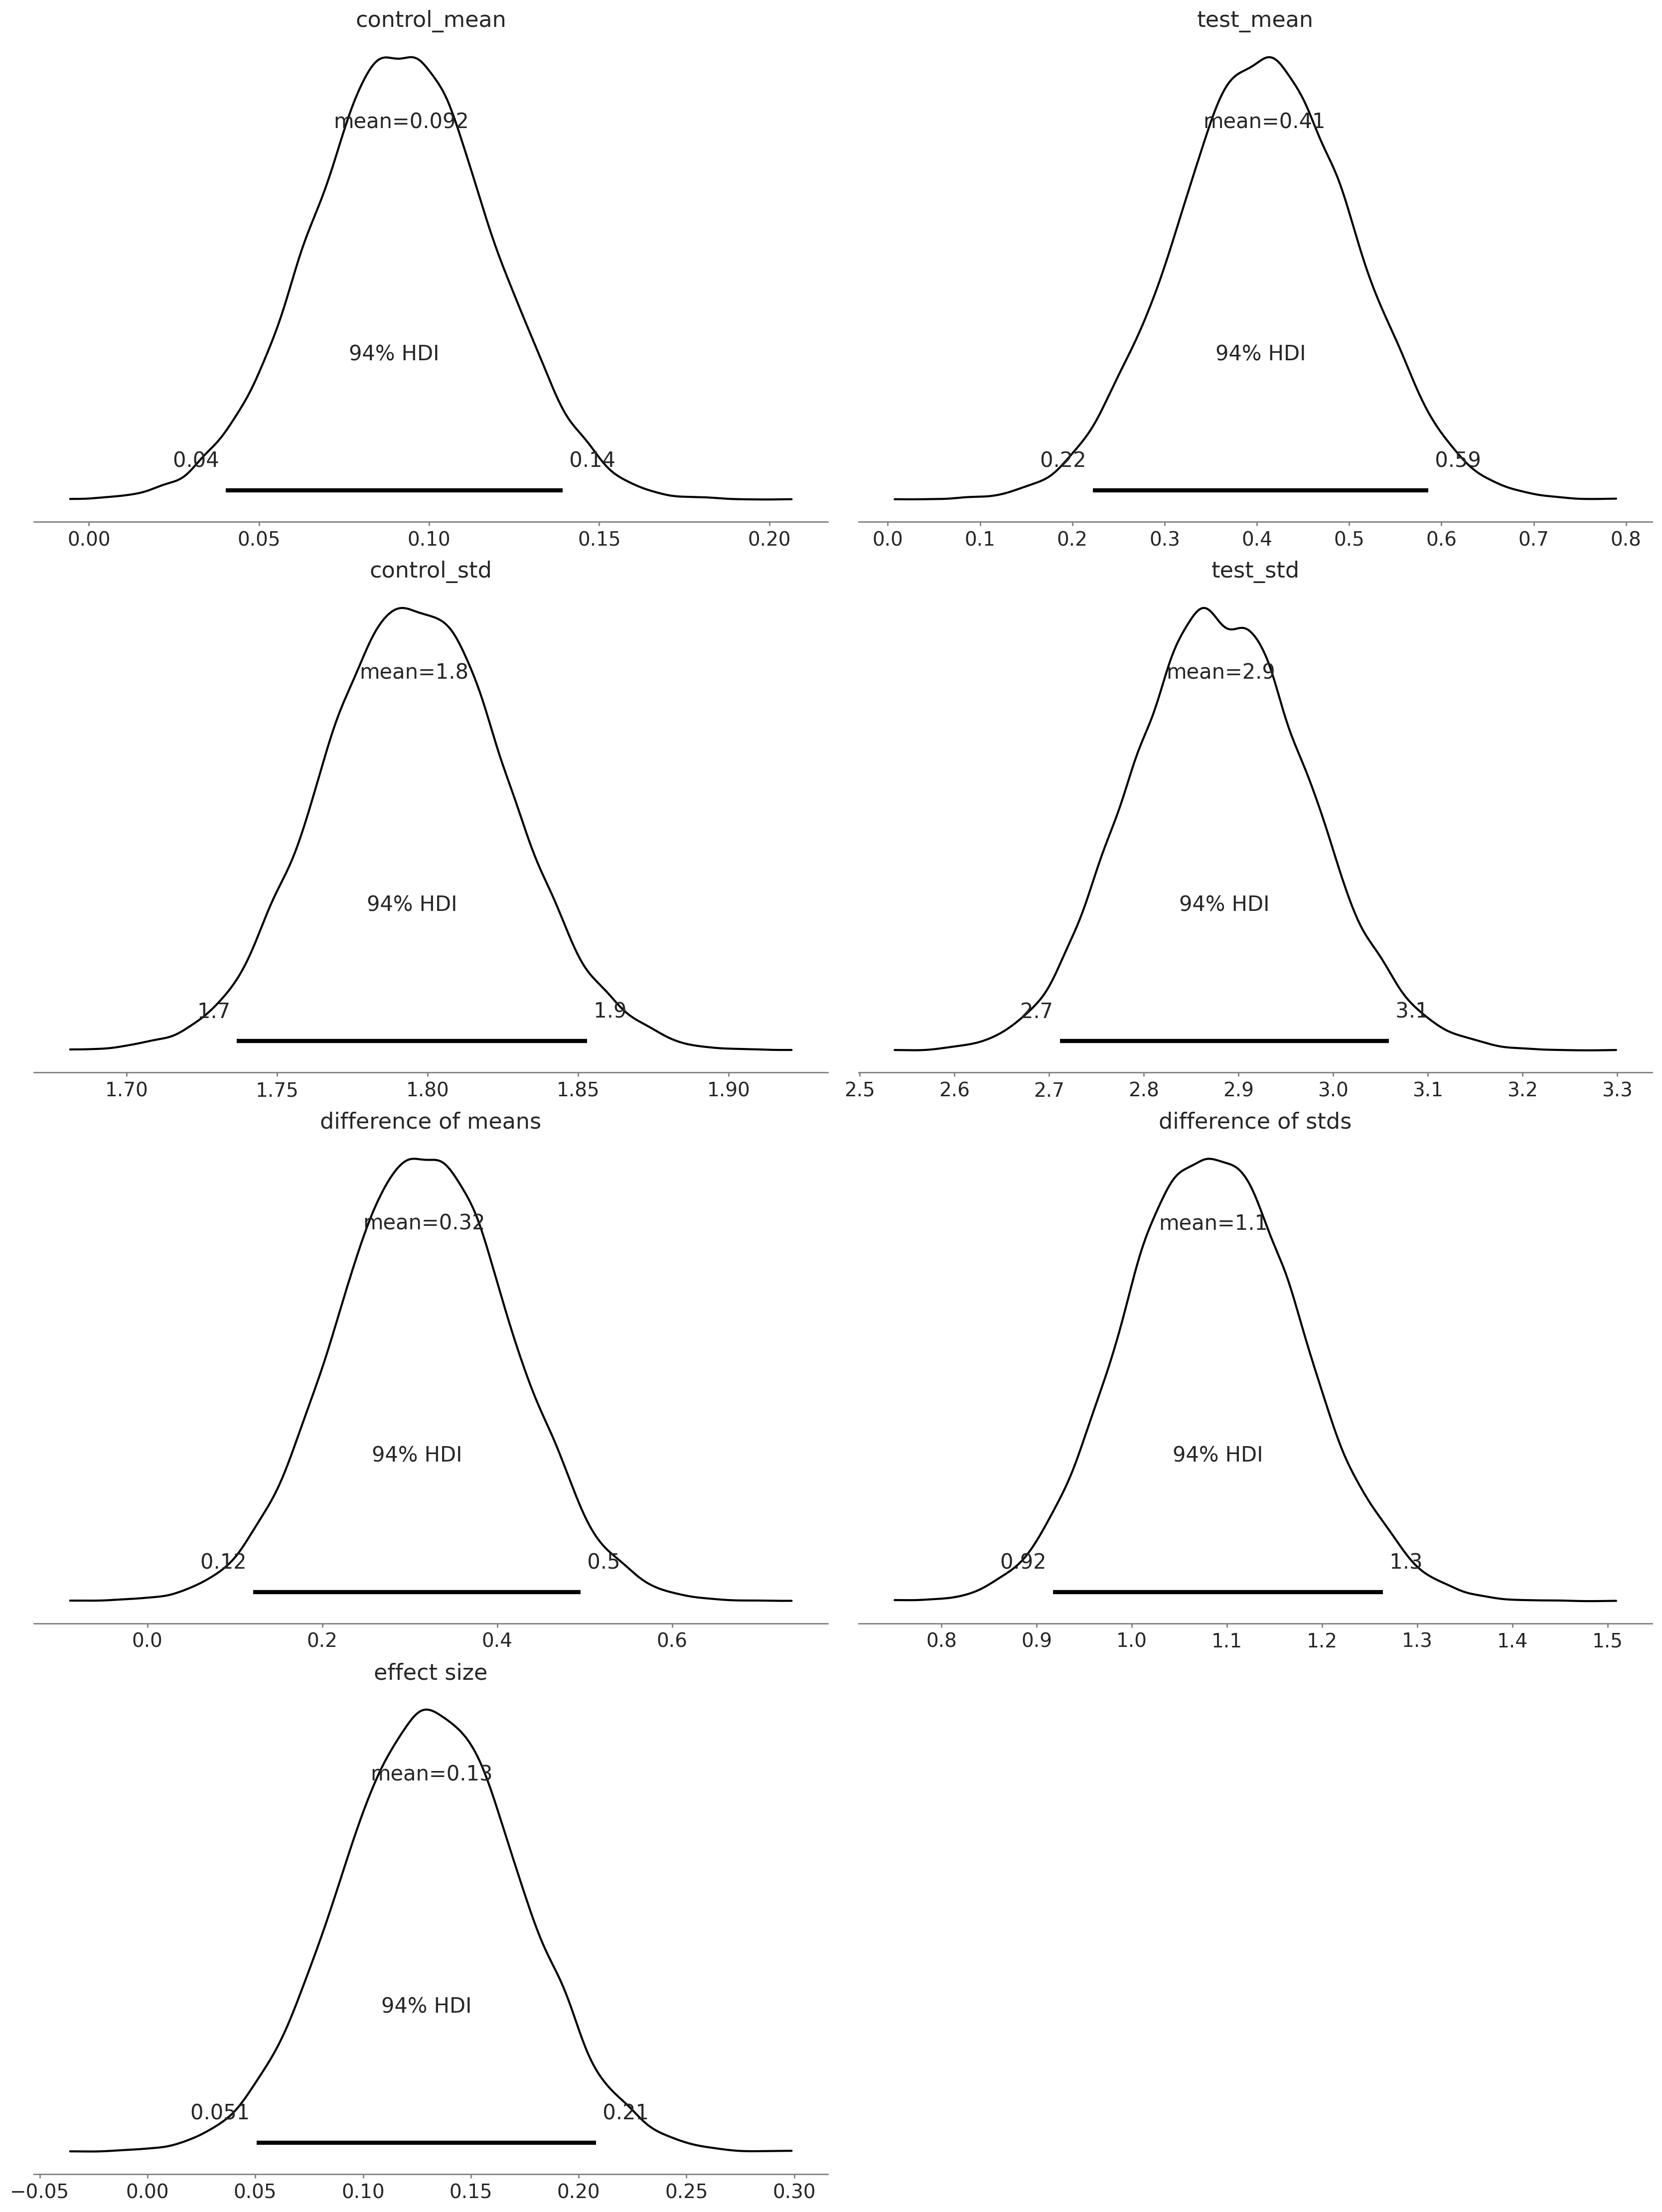

In [ ]:
az.plot_posterior(
    trace,
    var_names=['control_mean', 'test_mean', 'control_std', 'test_std', 'difference of means', 'difference of stds', 'effect size'],
    color='black',
    grid=(4, 2),
);

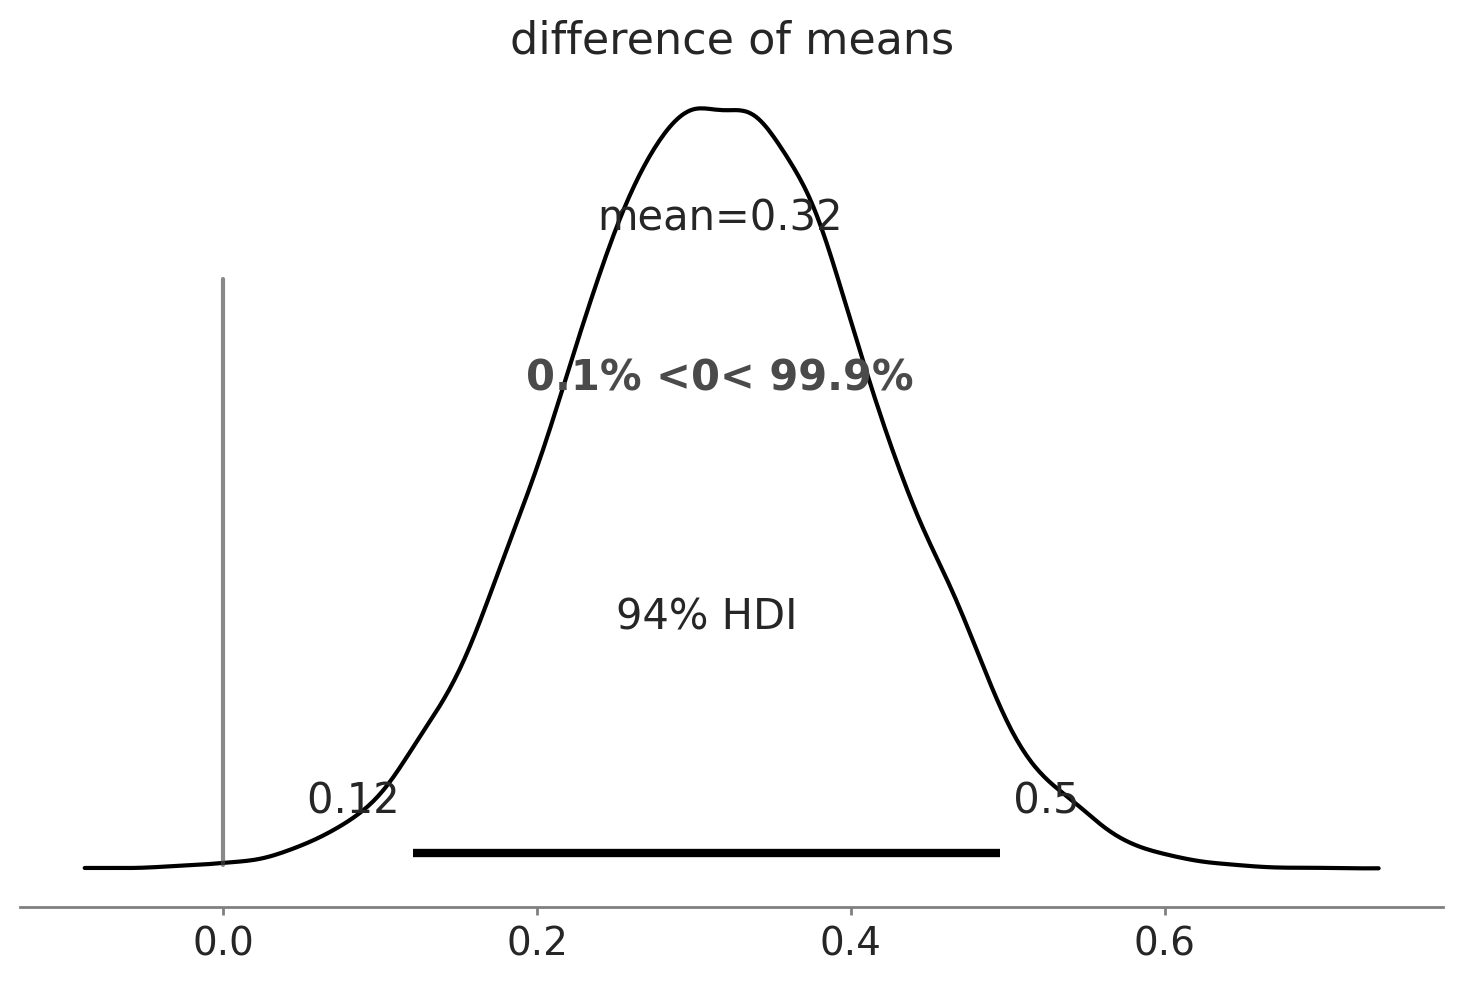

In [ ]:
az.plot_posterior(
    trace,
    ref_val = 0,
    var_names=['difference of means'],
    color='black',
);

[Text(0, 0, 'control_mean'),
 Text(1, 0, 'test_mean'),
 Text(2, 0, 'control_std'),
 Text(3, 0, 'test_std'),
 Text(4, 0, 'ν_minus_one'),
 Text(5, 0, 'difference of means'),
 Text(6, 0, 'difference of stds'),
 Text(7, 0, 'effect size')]

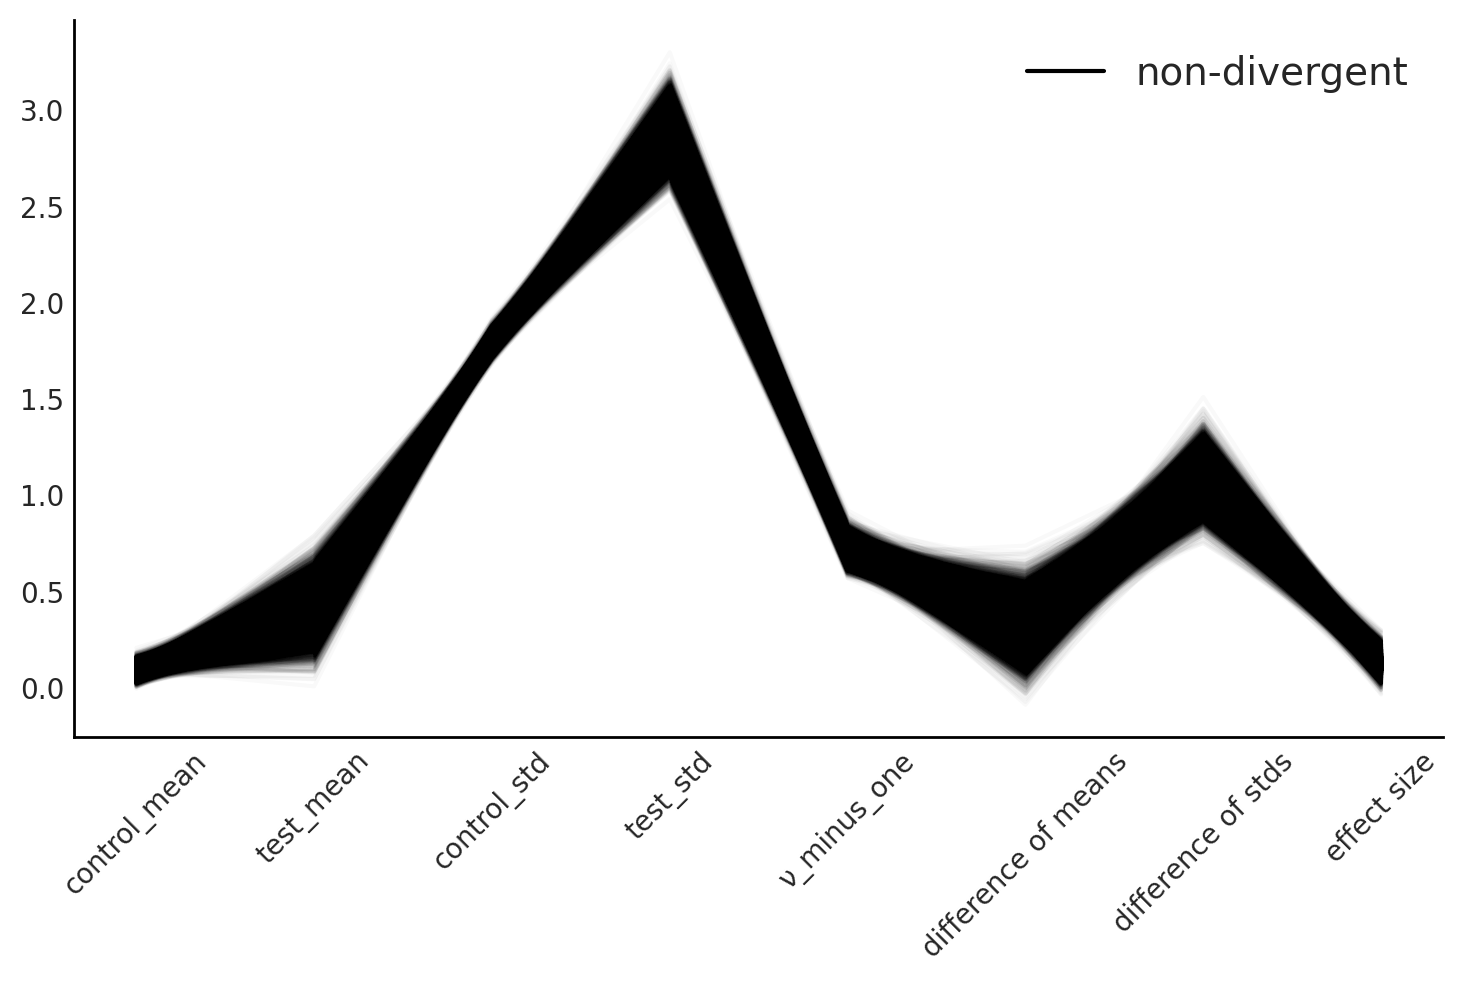

In [ ]:
ax = az.plot_parallel(trace)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

PREDICTIVE POSTERIOR

In [8]:
y = data.loc[data['sku'] == 'SKU_4_4']
y = y.fillna(0)
y2 = y.loc[y['Client Net'] == 'PhCh_9']
y2 = y2[y2['ofd_status_new'] == 1]['delta_rolling']

In [ ]:
μ_m = y.delta_rolling.mean()
μ_s = y.delta_rolling.std() * 2
σ_low = 1/10
σ_high = 10

with pm.Model() as model:
    test_mean = pm.Normal('test_mean', mu=μ_m, sigma=μ_s)

    test_std = pm.Uniform('test_std', lower=σ_low, upper=σ_high)

    ν = pm.Exponential('ν_minus_one', 1 / 29.0) + 1

    λ2 = test_std ** -2

    test = pm.StudentT('test', nu=ν, mu=test_mean, lam=λ2, observed=y2)  

with model:
    trace = pm.sample(10000)

/usr/local/lib/python3.10/dist-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


(-10.0, 10.0)

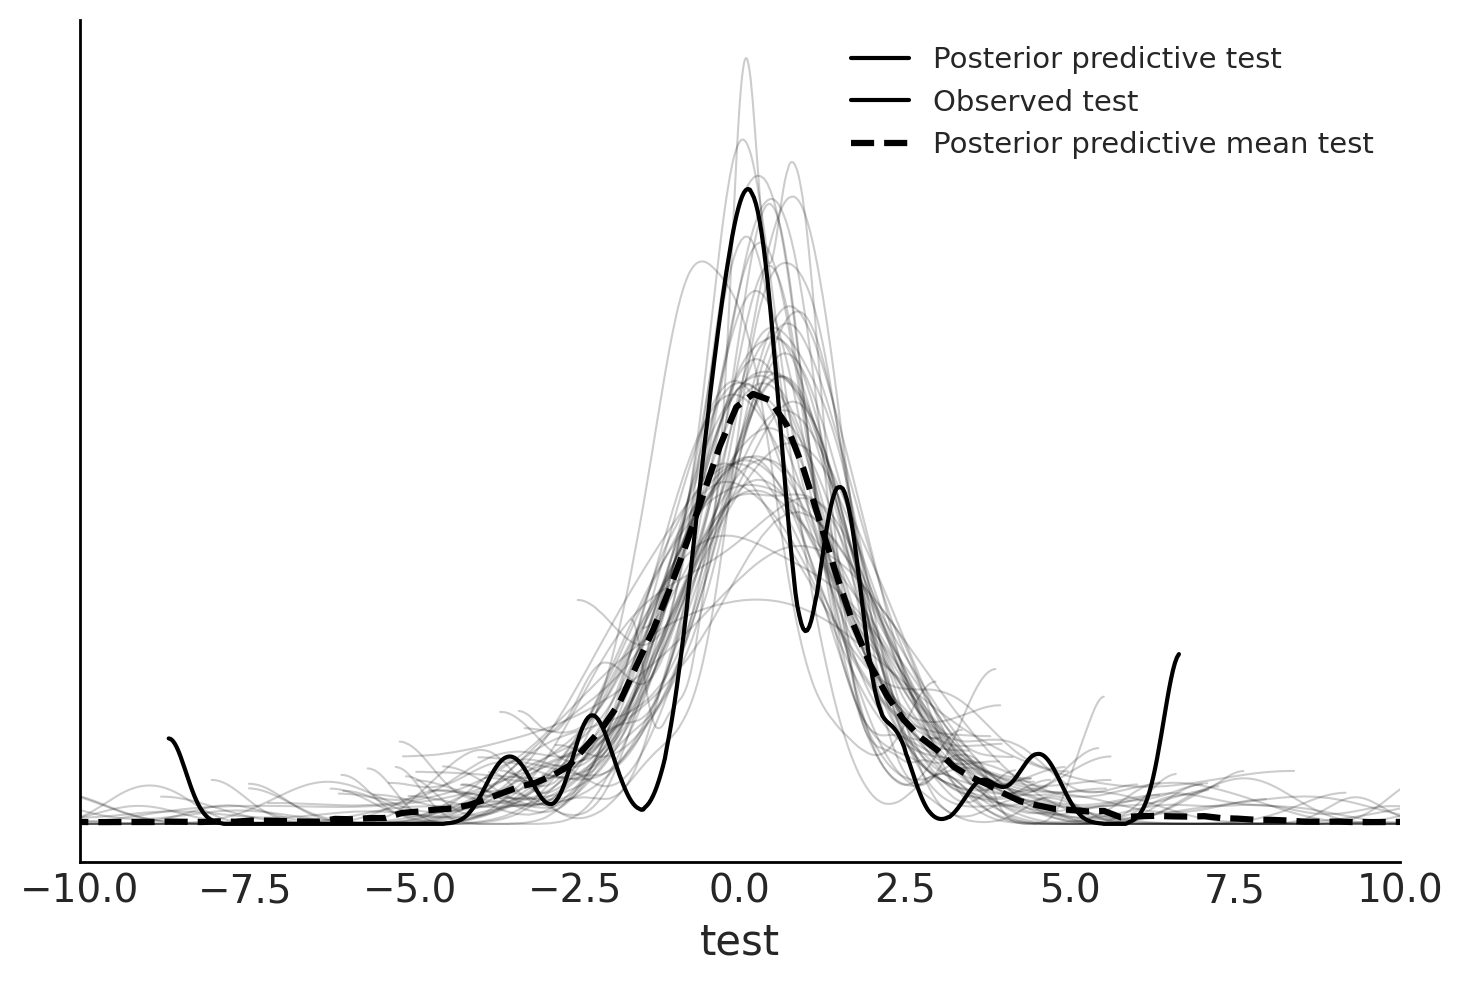

In [ ]:
y_ppc_t = pm.sample_posterior_predictive(
    trace, 50, model, random_seed=123)
y_pred_t = az.from_pymc3(trace=trace, posterior_predictive=y_ppc_t)
az.plot_ppc(y_pred_t, mean=True, observed=True, color='k')#, kind='cumulative')
plt.xlim(-10, 10)

In [ ]:
(y_pred_t.posterior.test_mean[0].mean() + y_pred_t.posterior.test_mean[1].mean())/2

<xarray.DataArray 'test_mean' ()>
array(0.3116685)

In [ ]:
with pm.Model() as model:
    test_mean = pm.Normal('test_mean', mu=4, sigma=0.5)

    test_std = pm.Uniform('test_std', lower=σ_low, upper=5.0)

    ν = pm.Exponential('ν_minus_one', 1 / 29.0) + 1

    λ2 = test_std ** -2

    test = pm.StudentT('test', nu=ν, mu=test_mean, lam=λ2, observed=y2)

with model:
    trace = pm.sample(10000)

/usr/local/lib/python3.10/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


/usr/local/lib/python3.10/dist-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


(-10.0, 10.0)

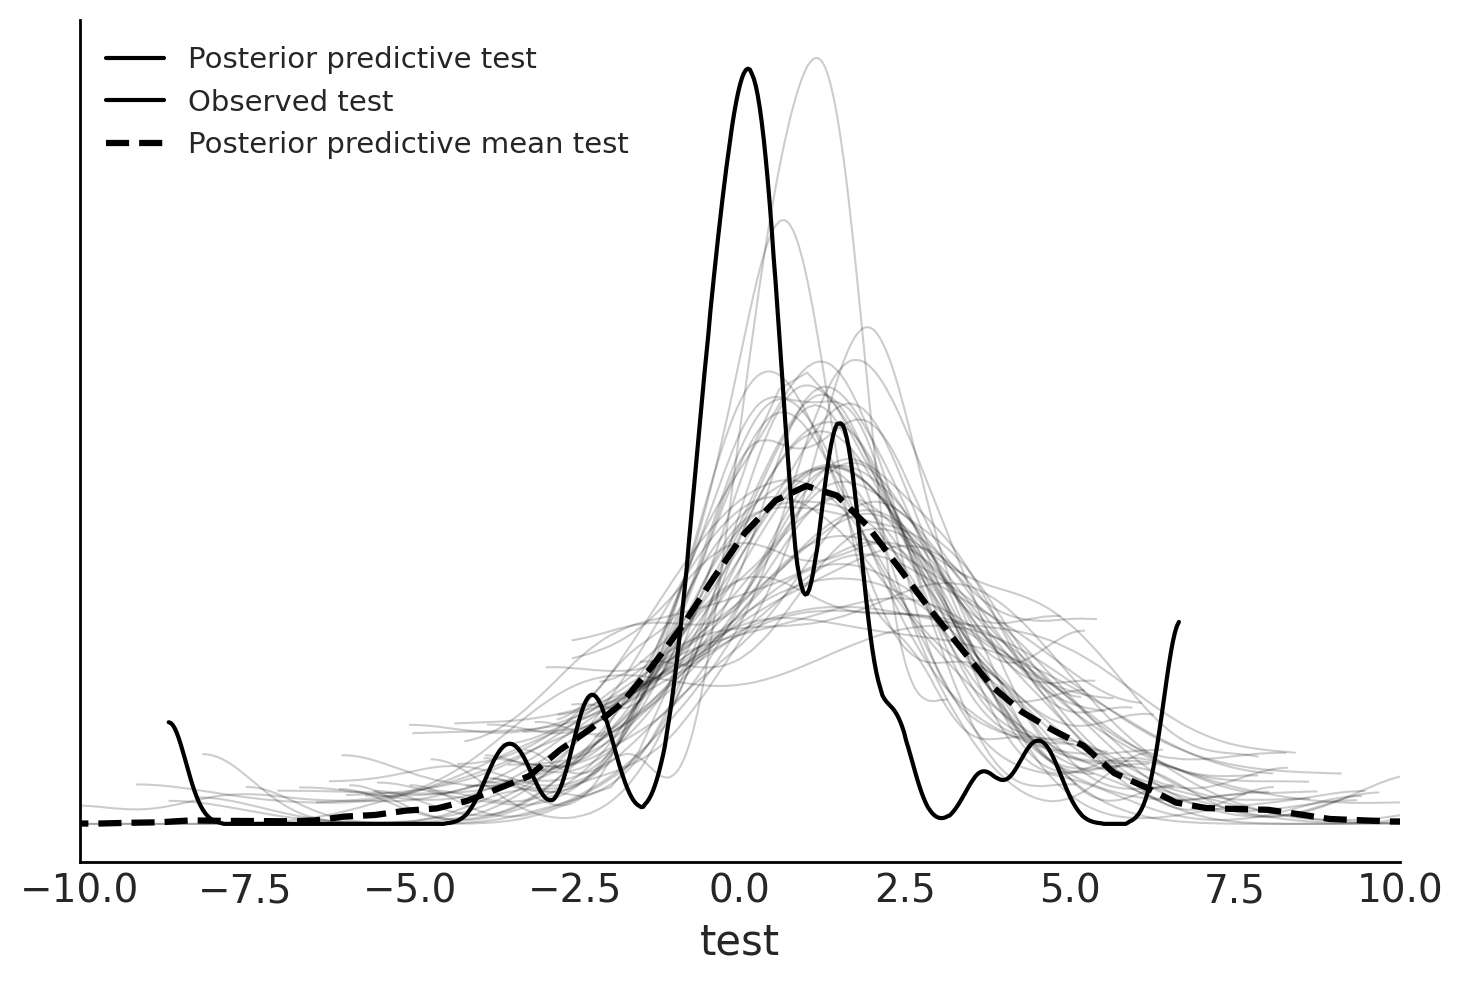

In [ ]:
y_ppc_t = pm.sample_posterior_predictive(
    trace, 50, model, random_seed=123)
y_pred_t = az.from_pymc3(trace=trace, posterior_predictive=y_ppc_t)
az.plot_ppc(y_pred_t, mean=True, observed=True, color='k')#, kind='cumulative')
plt.xlim(-10, 10)

In [ ]:
(y_pred_t.posterior.test_mean[0].mean() + y_pred_t.posterior.test_mean[1].mean())/2

<xarray.DataArray 'test_mean' ()>
array(1.19144391)

(-10.0, 10.0)

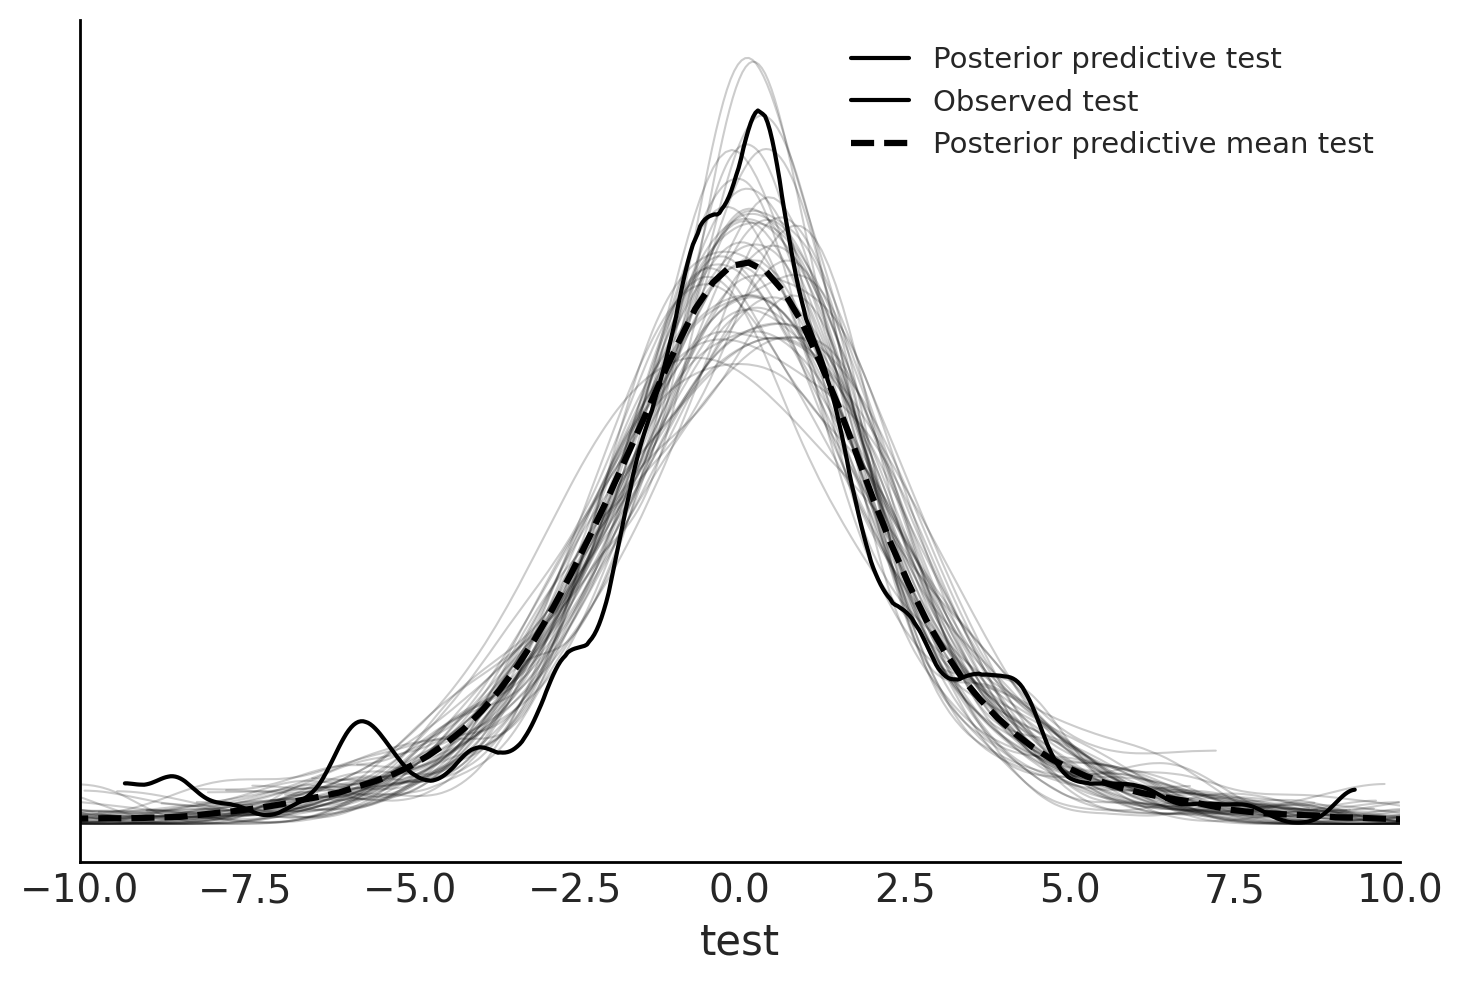

In [15]:
y2 = y.loc[y['Client Net'] == 'PhCh_139']
y2 = y2[y2['ofd_status_new'] == 1]['delta_rolling']

with pm.Model() as model:
    test_mean = pm.Normal('test_mean', mu=μ_m, sigma=μ_s)

    test_std = pm.Uniform('test_std', lower=σ_low, upper=σ_high)

    ν = pm.Exponential('ν_minus_one', 1 / 29.0) + 1

    λ2 = test_std ** -2

    test = pm.StudentT('test', nu=ν, mu=test_mean, lam=λ2, observed=y2)  

with model:
    trace = pm.sample(10000)

y_ppc_t = pm.sample_posterior_predictive(
    trace, 50, model, random_seed=123)
y_pred_t = az.from_pymc3(trace=trace, posterior_predictive=y_ppc_t)
az.plot_ppc(y_pred_t, mean=True, observed=True, color='k')#, kind='cumulative')
plt.xlim(-10, 10)

(-10.0, 10.0)

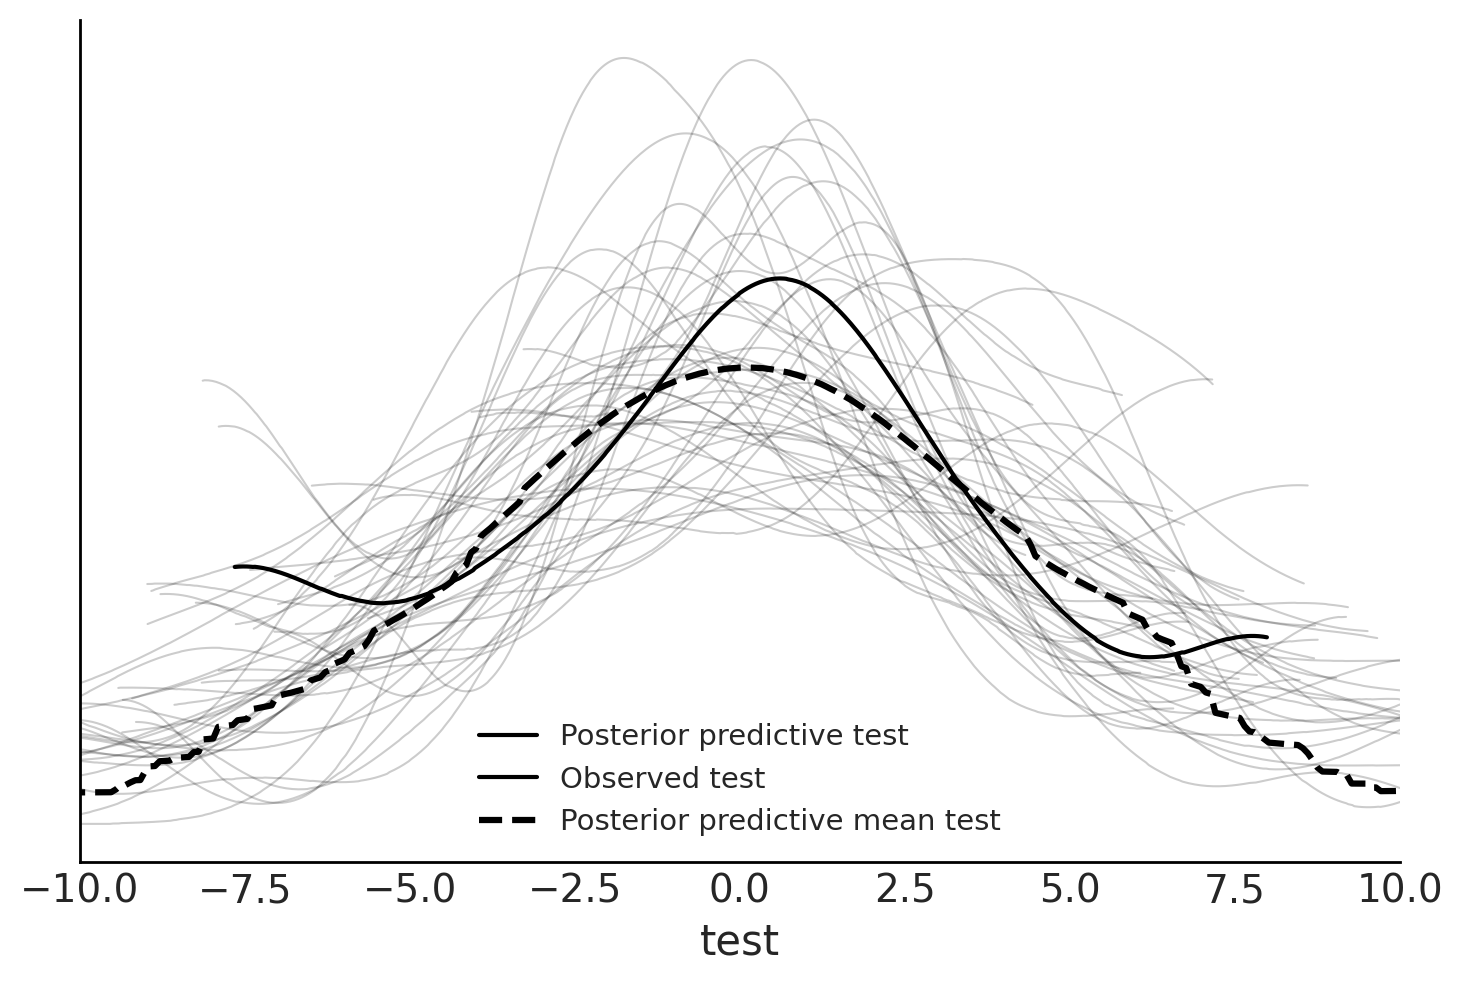

In [20]:
y2 = y.loc[y['Client Net'] == 'PhCh_123']
y2 = y2[y2['ofd_status_new'] == 1]['delta_rolling']

with pm.Model() as model:
    test_mean = pm.Normal('test_mean', mu=μ_m, sigma=μ_s)

    test_std = pm.Uniform('test_std', lower=σ_low, upper=σ_high)

    ν = pm.Exponential('ν_minus_one', 1 / 29.0) + 1

    λ2 = test_std ** -2

    test = pm.StudentT('test', nu=ν, mu=test_mean, lam=λ2, observed=y2)  

with model:
    trace = pm.sample(5000)

y_ppc_t = pm.sample_posterior_predictive(
    trace, 50, model, random_seed=123)
y_pred_t = az.from_pymc3(trace=trace, posterior_predictive=y_ppc_t)
az.plot_ppc(y_pred_t, mean=True, observed=True, color='k')#, kind='cumulative')
plt.xlim(-10, 10)